## Generation-time branch attraction

This notebook focuses on Ne effects

In [1]:
import toytree
import toyplot, toyplot.svg
import ipcoal
import numpy as np
import ipyrad.analysis as ipa

### Simulation scenario with deep divergences (crown 25Ma)

In [2]:
# get an ultrametric imbalanced tree
tree = toytree.rtree.baltree(16, treeheight=25e6)
tree.draw(ts='p');

<svg class="toyplot-canvas-Canvas" height="265.0px" id="tdd877246839847958d0f17d227f6a064" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 265.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11 r12 r13 r14 r15 0 12500000 25000000

In [3]:
# store the alphanumeric order of names on the tree
NAMEORDER = tree.get_tip_labels()

### Species tree in units of generations
To setup a simulation on this tree we need branch lengths to be in units of generations. If we assume that 1 generation = 1 year then nothing has to be done. Here we assume that generations times are 1 for half of the taxa on the tree, but 1 generation = 10 years for several other taxa. The tree below shows that this looks like in terms of the transformed branch lengths. 

In [4]:
# set gentime on nodes
ntree = tree.set_node_values(
    feature="Ne", values={i: 1e6 for i in (0,1,16,4,5,18,8,9,20,12,13,22)}, default=10e6,
)

In [5]:
ntree.draw(ts='p', width=400, node_sizes=0, node_labels=False, edge_type='p');

<svg class="toyplot-canvas-Canvas" height="265.0px" id="tdf6782c57c154d3789cce1aebe245382" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 265.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11 r12 r13 r14 r15 0 12500000 25000000

### Example sequential genealogies

In [6]:
# visualize tree with edge lengths in absolute time
model = ipcoal.Model(ntree, seed=12345)
model.sim_trees(4)
toytree.mtree(model.df.genealogy).draw(ts='n', layout='d', height=225, width=900);

<svg class="toyplot-canvas-Canvas" height="225.0px" id="t92843590741a4d41bf0e0a5dfa1a4a88" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 900.0 225.0" width="900.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r13 r12 r14 r15 r11 r9 r8 r10 r7 r5 r4 r6 r1 r0 r2 r3 r9 r8 r11 r10 r13 r12 r1 r0 r3 r7 r6 r5 r4 r2 r15 r14 r13 r12 r14 r10 r15 r7 r6 r9 r8 r11 r5 r4 r3 r2 r1 r0 r7 r6 r3 r1 r0 r14 r10 r5 r4 r2 r13 r12 r15 r9 r8 r11

### Are branches attracted by generation times on true genealogies?

In [7]:
# simulate 2K unlinked genealogies
model.sim_trees(2000)
trees = toytree.mtree(model.df.genealogy)

In [8]:
# convert simulated genealogies branch lengths from generations to E(seq.div.)
for tree in trees.treelist:
    for node in tree.treenode.traverse():
        node.dist = node.dist * 1e-8

In [9]:
def topo_dist(t1):
    """
    Return alphanumeric name ordered array of topo dist between all nodes on a tree
    """
    # array of tips in alphanumeric ordr
    arr = np.zeros((len(t1), len(t1)), dtype=float)
    
    # iterate to compare all tips to tips
    labels = NAMEORDER  # sorted(t1.get_tip_labels())
    for idx1 in range(len(t1)):
        for idx2 in range(len(t1)):
            if idx1 != idx2:
                
                # get distance between tips on every tree
                node1 = t1.idx_dict[idx1]
                node2 = t1.idx_dict[idx2]
                dist = node1.get_distance(node2, topology_only=True)
                nidx1 = labels.index(node1.name)
                nidx2 = labels.index(node2.name)
                arr[nidx1, nidx2] = dist
    return arr

In [10]:
def sequential_dist(trees):
    """
    Return array of topo dists between nodes on sequential trees in ordered input.
    """
    arrs = []
    dists = None
    for tree in trees:
        if dists is not None:
            diff = abs(dists - topo_dist(tree))
            arrs.append(diff)
        dists = topo_dist(tree)
    return np.array(arrs)

The average distance between some nodes is greater or lesser than others, but only because the variance in position of some nodes is greater than others. The same effect would be seen if Ne was simply greater on some branches than others (TODO: show this side by side). 

In [11]:
def plot_matrix(dat):
    
    # get min and max of the off-diagonal elements
    dat = dat.copy()
    dat[np.diag_indices_from(dat)] = dat.mean()
    cmap = toyplot.color.LinearMap(domain_min=dat.min(), domain_max=dat.max())
    canvas = toyplot.Canvas(320, 300)
    ax1 = canvas.table(rows=dat.shape[0], columns=dat.shape[1], bounds=(50, 250, 50, 250))

    # apply colors to cells but not diagonals
    for ridx in range(dat.shape[0]):
        for cidx in range(dat.shape[1]):
            
            if ridx == cidx:
                ax1.cells.cell[ridx, cidx].style = {'fill': 'grey', 'stroke': 'none'}
            else:
                col = cmap.color(dat[ridx, cidx])
                ax1.cells.cell[ridx, cidx].style = {'fill': col, 'stroke': 'none'}

    # style spacing between grid cells            
    ax1.body.gaps.columns[...] = 1
    ax1.body.gaps.rows[...] = 1

    # add a colorbar to canvas
    numberline = canvas.numberline(270, 250, 270, 50)
    numberline.colormap(cmap, style={"stroke-width":5})
    numberline.axis.ticks.locator = toyplot.locator.Extended(only_inside=True)
    return canvas, ax1

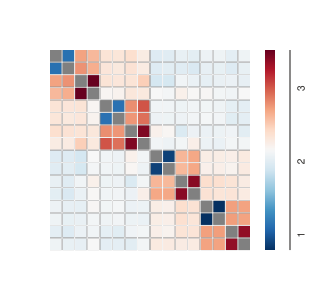

In [13]:
# plot the avg. difference between UNLINKED trees
dat = sequential_dist(trees.treelist).var(axis=0)
c, t = plot_matrix(dat);
toyplot.svg.render(c, "../figures/fig-1-vn-unlinked-var.svg")
c

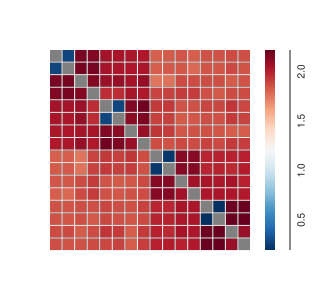

In [14]:
# plot the avg. difference between UNLINKED trees
dat = sequential_dist(trees.treelist).mean(axis=0)
c, t = plot_matrix(dat);
toyplot.svg.render(c, "../figures/fig-1-vn-unlinked-mean.svg")
c

### Multi-species coalescent is not affected with True genealogies
With unlinked genealogies the greater variance in position of taxa with long generations times is no different than the greater variance caused by differences in Ne. In other words, generation time can be ignored since it the Ne parameter can effectively suck up any variance explained by differences in generation time.

In [15]:
# # infer a species tree
# ast = ipa.astral([i.write() for i in trees])
# ast.run()

In [16]:
# assume julia & snaq are already installed.
# needs to parse the returned network into major tree + edge tuples
# snaq = ipa.snaq()

In [17]:
# toytree.tree(ast.tree).root(regex='r[0-8]').draw(layout='d');

### LINKED GENEALOGIES

In [18]:
# simulate 2K unlinked genealogies
model.sim_trees(nloci=1, nsites=50000)
trees = toytree.mtree(model.df.genealogy)
print(len(trees))

10741


In [19]:
# convert simulated genealogies branch lengths from generations to E(seq.div.)
for tree in trees.treelist:
    for node in tree.treenode.traverse():
        node.dist = node.dist * 1e-8

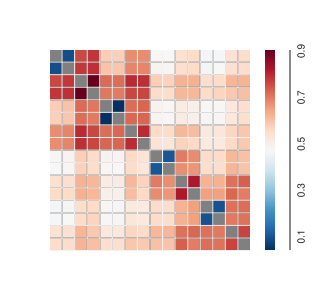

In [20]:
# plot the avg. difference between sequential trees
dat = sequential_dist(trees.treelist).var(axis=0)
c, t = plot_matrix(dat);
toyplot.svg.render(c, "../figures/fig-1-vn-linked-var.svg")
c

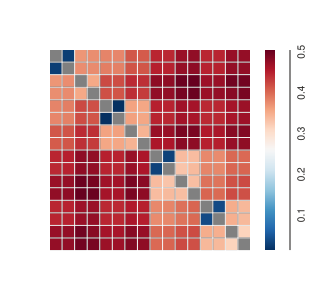

In [21]:
# plot the avg. difference between sequential trees
dat = sequential_dist(trees.treelist).mean(axis=0)
c, t = plot_matrix(dat);
toyplot.svg.render(c, "../figures/fig-1-vn-linked-mean.svg")
c

### Plot the rate of change spatially among nodes on the tree
The average delta-genetic-distance between nodes in sequential trees...

In [12]:
# tree.treenode.get_distance()

### Simulate sequence data on genealogies under a GTR model

In [13]:
# simulate loci that are each 3000bp in length
model.sim_loci(nloci=5, nsites=3e3)
model.write_loci_to_hdf5(name="var-n", outdir="db")

wrote 5 loci to /home/deren/Documents/gentime-attraction/notebooks/db/var-n.seqs.hdf5


In [26]:
# # overlay a genealogy on the true tree
# et = toytree.tree(model.df.inferred_tree[0]).root(regex='r[0-8]')
# c, a, m = et.draw(ts='c', fixed_order=tree.get_tip_labels(), use_edge_lengths=False, tip_labels=True);

<svg class="toyplot-canvas-Canvas" height="265.0px" id="taa1f9083f5674d7fadac89e179b4d614" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 265.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r2 r3 r1 r0 r7 r6 r4 r5 r14 r15 r13 r12 r8 r11 r10 r9 0 4 8